# Getting Started with OPERA DIST-ALERT-HLS Products

## Streaming and visualizing Cloud-Optimized GeoTIFF (COG) OPERA DIST-ALERT-HLS products using CMR's SpatioTemporal Asset Catalog (CMR-STAC)

### This tutorial demonstrates how to query and work with the OPERA DIST-ALERT-HLS Provisional Data products from the cloud ([OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0](https://lpdaac.usgs.gov/products/opera_l3_dist-alert-hls_provisional_v0v000/)).
---

### Data Used in the Example

* **30 meter (m) global OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 provisional product (Version 0) - [OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0](https://lpdaac.usgs.gov/products/opera_l3_dist-alert-hls_provisional_v0v000/)**<br>
    - The Observational Products for End-Users from Remote Sensing Analysis (OPERA) Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 (HLS) provisional data product Version 0 maps vegetation disturbance alerts from data collected by Landsat 8 and Landsat 9 Operational Land Imager (OLI) and Sentinel-2A and Sentinel-2B Multi-Spectral Instrument (MSI). Vegetation disturbance alert is detected at 30 meter (m) spatial resolution when there is an indicated decrease in vegetation cover within an HLS pixel. The product also provides auxiliary generic disturbance information as determined from the variations of the reflectance through the HLS scenes to provide information about more general disturbance trends. HLS data represent the highest temporal frequency data available at medium spatial resolution. The combined observations will provide greater sensitivity to land changes, whether of large magnitude/short duration, or small magnitude/long duration.
    - The OPERA_L3_DIST-ALERT-HLS (or DIST-ALERT) data product is provided in Cloud Optimized GeoTIFF (COG) format, and each layer is distributed as a separate file. There are 19 layers contained within in the DIST-ALERT product: vegetation disturbance status, current vegetation cover indicator, current vegetation anomaly value, historical vegetation cover indicator, max vegetation anomaly value, vegetation disturbance confidence layer, date of initial vegetation disturbance, number of detected vegetation loss anomalies, and vegetation disturbance duration. See the Product Specification for a more detailed description of the individual layers provided in the DIST-ALERT product.
* **Science Dataset (SDS) Layers**
    - VEG_ANOM_MAX (Maximum Vegetation Anomaly Layer)
    - VEG_DIST_DATE (Vegetation Disturbance Date Layer)
    - VEG_DIST_STATUS (Vegetation Disturbance Status Layer)

Please refer to the [OPERA DIST Product Specification Document](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DIST_HLS.pdf) for details about the DIST-ALERT-HLS product.
<br><br>

---
<br> 

## Topics Covered
> 1. Getting Started
> 2. CMR-STAC API: Search for data based on spatial query
> 3. Load and visualize DIST-ALERT-HLS COGs from the Cloud
> 4. Demonstrate time slider visualization tool
<br>
---
<br>

## Before Starting this Tutorial
A [NASA Earthdata Login](https://urs.earthdata.nasa.gov) account is required to download the data used in this tutorial. You can create an account using the link provided.
<br><br>
---


## 1. Getting Started <br>
### 1.1 Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Notebook dependencies
import os
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

from pystac_client import Client  
from pystac_client import ItemSearch
from pystac.item import Item
from typing import Dict, Any
import json

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
from tqdm import tqdm
import math

from shapely.geometry import box
from shapely.geometry import shape
from shapely.ops import transform

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from skimage import io

from osgeo import gdal
import rasterio as rio
import rioxarray
from rioxarray.merge import merge_arrays

import folium
from folium import plugins

import pyproj
from pyproj import Proj

import xarray as xr
import panel as pn
import panel.widgets as pnw
import geoviews as gv
import hvplot.xarray
import holoviews as hv

from bokeh.models import FixedTicker
hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

import warnings
warnings.filterwarnings('ignore')

from Stream_and_Viz_DIST_Functions import intersection_percent, stack_bands, time_and_area_cube, compute_area, standard_date, colorize, mask_rasters, getbasemaps, transform_data_for_folium


### 1.2 Set Up Working Environment

In [3]:
inDir = os.getcwd()
os.chdir(inDir)

### 1.3 Generate Authentication Token

The cell below generates an authentication token and asks for your Earthdata username/password the first time if netrc does not exist in your home directory.

In [4]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [5]:
# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

## 2. CMR_STAC API: Search for Data Based on Spatial Query and Cloud Cover

### 2.1 Initialize User-Defined Parameters

The user should only specify parameters in the cell directly below, indicating:
* **Area of Interest**: coordinates entered as a shapely.geometry box object
* **Start and Stop Dates of Interest**: default stop date is set as present day
* **Overlap Threshold**: minimum required % spatial overlap between the AOI and DIST tiles obtained through search for DIST tile to be deemed "acceptable"
* **Cloud Cover Threshold**: maximum % cloud cover allowed for a DIST tile to be deemed "acceptable"


In [6]:
# User-Defined Parameters
# aoi = box(67.991, 27.051, 68.002, 27.089)
aoi = box(-105.3259771, 35.1544515,-104.8928408, 36.1448493)
start_date = datetime(2022, 1, 1)                                   
stop_date = f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"         
overlap_threshold = 50                                                  
cloud_cover_threshold = 20                                           

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2022-01-01 00:00:00 and 2023-05-16 23:59:59
With AOI: {'type': 'Polygon', 'coordinates': (((-104.8928408, 35.1544515), (-104.8928408, 36.1448493), (-105.3259771, 36.1448493), (-105.3259771, 35.1544515), (-104.8928408, 35.1544515)),)}


In [7]:
# Search data through CMR-STAC API
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "limit": 50,
                 "max_items": 1000
                }
search_dist = api.search(**search_params)

### 2.2 Query DIST-ALERT-HLS tiles based on cloud cover and spatial overlap with respect to defined AOI

In [8]:
# Filter datasets based on spatial overlap and cloud cover
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_dist.items()])

# Check percent cloud cover values
print("\nPercent cloud cover before filtering: ")
print([f"{i.properties['eo:cloud_cover']}" for i in search_dist.items()])

Percent overlap before filtering: 
['2.21', '68.61', '3.54', '24.78', '8.68', '2.21', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '2.21', '8.99', '99.90', '24.78', '8.85', '2.22', '2.21', '3.25', '65.15', '24.78', '8.36', '2.21', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '8.99', '2.21', '99.90', '8.85', '24.78', '2.22', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '2.21', '24.78', '68.36', '3.52', '8.66', '2.21', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '2.21', '8.99', '24.78', '2.22', '8.85', '99.90', '2.21', '24.78', '3.30', '65.76', '8.43', '2.21', '2.21', '8.99', '2.21', '8.95', '38.77', '8.85', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '2.21', '8.99', '8.85', '2.22', '24.78', '99.90', '2.21', '3.20', '24.78', '64.69', '8.32', '2.21', '2.21', '8.99', '24.78', '99.90', '2.21', '8.85', '8.99', '2.21', '24.78', '2.22', '8.85', '99.90', '2.21', '24.78', '63.37', '3.10', '8.22', '2.21', '2.21', '8.99',

The percent spatial overlap values above vary from only 40% to  a perfect 100%. The following filtering process will only keep tiles with spatial overlap greater than 50%. Similarly, cloud cover values ranging from 0 to 100 can be observed above. The filtering process will also only keep tiles with less than 20% cloud cover.

In [9]:
# Apply spatial overlap and cloud cover threshold
dist_filtered = (
    i for i in search_dist.items() if (intersection_percent(i, intersects_geometry) 
                                       > overlap_threshold and 
                                       i.properties['eo:cloud_cover'] < cloud_cover_threshold)
)

Inspecting one DIST tile from the filtered query, its metadata can be easily accessed as seen below.

In [10]:
dist_data = list(dist_filtered)

dist_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'OPERA_L3_DIST-ALERT-HLS_T13SDV_20230227T173234Z_20230301T133825Z_L9_30_v0',
 'properties': {'eo:cloud_cover': 3,
  'datetime': '2023-02-27T17:32:34.868000Z',
  'start_datetime': '2023-02-27T17:32:34.868Z',
  'end_datetime': '2023-02-27T17:32:58.751Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-105.3259771, 35.1544515],
    [-104.8928408, 35.1548427],
    [-104.8915104, 36.1448493],
    [-105.0542448, 36.1448861],
    [-105.3259771, 35.1544515]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0/items/OPERA_L3_DIST-ALERT-HLS_T13SDV_20230227T173234Z_20230301T133825Z_L9_30_v0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HL

In [11]:
# Print search information
# Total granules
print(f"Total granules after search filter: {len(dist_data)}")

# Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dist_data])

# Check cloud cover values
print("Cloud-cover: ")
print([f"{x.properties['eo:cloud_cover']}" for x in dist_data])

Total granules after search filter: 17
Percent-overlap: 
['68.61', '99.90', '99.90', '99.90', '99.90', '99.90', '64.69', '99.90', '99.90', '63.37', '99.90', '67.27', '99.90', '99.90', '99.90', '99.90', '69.94']
Cloud-cover: 
['3', '6', '3', '4', '3', '5', '5', '1', '7', '10', '10', '1', '4', '16', '1', '4', '0']


Observing percent spatial overlap and cloud cover values after filtering, it is evident that only DIST tiles covering most of the AOI with minimal cloud cover are now available to the user.<br><br>In the figure produced below, the overlap between the boundary of the AOI and varying DIST tile boundaries is shown over a basemap.

In [12]:
# Visualize the DIST tile boundary and the user-defined box
geom_df = []
for d,_ in enumerate(dist_data):
    geom_df.append(shape(dist_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})
granules_poly = gv.Polygons(geom_granules).opts(line_color='blue', color=None)

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=1000, height=1000)

# Get the user-specified aoi
geom_aoi = shape(intersects_geometry)
aoi_poly = gv.Polygons(geom_aoi).opts(line_color='yellow', color=None)

# Plot using geoviews wrapper
granules_poly*base*aoi_poly

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

DIST tiles adhering to the spatial overlap and cloud cover thresholds can be sorted in the table below, listing each tile's spatial coverage, cloud cover, and bandlink.

In [13]:
# Create table of search results
dist_data_df = []
for item in dist_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    sensor = fn[6]
    dat = item.datetime.strftime('%Y-%m-%d')
    spatial_coverage = intersection_percent(item, intersects_geometry)
    cloud_cover = item.properties['eo:cloud_cover']
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    dist_data_df.append([ID,sensor,dat,geom,bbox,spatial_coverage,cloud_cover,band_links])

dist_data_df = pd.DataFrame(dist_data_df, columns = ['TileID', 'Sensor', 'Date', 'Coords', 'bbox','SpatialCoverage','CloudCover','BandLinks'])
dist_data_df

TileID Sensor        Date  \
0   T13SDV     L9  2023-02-27   
1   T13SDV    S2A  2023-02-27   
2   T13SDV     L8  2023-03-14   
3   T13SDV    S2B  2023-03-14   
4   T13SDV    S2A  2023-03-29   
5   T13SDV     L8  2023-03-30   
6   T13SDV     L9  2023-03-31   
7   T13SDV    S2B  2023-04-03   
8   T13SDV     L9  2023-04-07   
9   T13SDV     L8  2023-04-08   
10  T13SDV     L8  2023-04-15   
11  T13SDV     L9  2023-04-16   
12  T13SDV    S2A  2023-04-18   
13  T13SDV    S2B  2023-04-23   
14  T13SDV    S2A  2023-05-08   
15  T13SDV     L9  2023-05-09   
16  T13SDV     L8  2023-05-10   

                                               Coords  \
0   {'type': 'Polygon', 'coordinates': [[[-105.325...   
1   {'type': 'Polygon', 'coordinates': [[[-106.098...   
2   {'type': 'Polygon', 'coordinates': [[[-106.098...   
3   {'type': 'Polygon', 'coordinates': [[[-106.098...   
4   {'type': 'Polygon', 'coordinates': [[[-106.098...   
5   {'type': 'Polygon', 'coordinates': [[[-106.098...   
6   {'type': 'Polygon', 'coordinates': [[[-105.308...   
7   {'type': 'Polygon', 'coordinates': [[[-106.098...   
8   {'type': 'Polygon', 'coordinates': [[[-106.098...   
9   {'type': 'Polygon', 'coordinates': [[[-105.303...   
10  {'type': 'Polygon', 'coordinates': [[[-106.098...   
11  {'type': 'Polygon', 'coordinates': [[[-105.320...   
12  {'type': 'Polygon', 'coordinates': [[[-106.098...   
13  {'type': 'Polygon', 'coordinates': [[[-106.098...   
14  {'type': 'Polygon', 'coordinates': [[[-106.098...   
15  {'type': 'Polygon', 'coordinates': [[[-106.098...   
16  {'type': 'Polygon', 'coordinates': [[[-105.331...   

                                               bbox  SpatialCoverage  \
0   [-105.325977, 35.154452, -104.89151, 36.144898]        68.613426   
1   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
2   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
3   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
4   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
5   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
6    [-105.30885, 35.154496, -104.89151, 36.144849]        64.686139   
7   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
8   [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
9    [-105.30325, 35.154511, -104.89151, 36.144898]        63.372565   
10  [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
11  [-105.320048, 35.154467, -104.89151, 36.144898]        67.274671   
12  [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
13  [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
14  [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
15  [-106.111925, 35.149912, -104.89151, 36.144896]        99.903469   
16  [-105.331577, 35.154436, -104.89151, 36.144898]        69.939318   

    CloudCover                                          BandLinks  
0            3  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
1            6  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
2            3  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
3            4  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
4            3  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
5            5  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
6            5  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
7            1  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
8            7  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
9           10  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
10          10  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
11           1  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
12           4  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
13          16  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
14           1  [https://data.lpdaac.earthdatacloud.nasa.gov/l...

## 3. Load and Visualize DIST-ALERT-HLS COGs from the Cloud

If one tile is extracted from the filtered collection and its layers are examined, all 19 product layers are produced.

In [14]:
# Instead of reading in band links, need to project to folium's projection and merge tiles

# Need to implement transform_data_for_folium function in .py file
T42RUR_VEG_ANOM_MAX, T42RUR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[4])
T42RVR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[4])
merged_VEG_ANOM_MAX = merge_arrays([T42RUR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX])


T42RUR_VEG_DIST_DATE, T42RUR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[6])
T42RVR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[6])
merged_VEG_DIST_DATE = merge_arrays([T42RUR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE])

T42RUR_VEG_DIST_STATUS, T42RUR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[0])
T42RVR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[0])
merged_VEG_DIST_STATUS = merge_arrays([T42RUR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS])

In [15]:
masked_VEG_ANOM_MAX, masked_VEG_DIST_DATE,masked_VEG_DIST_STATUS = mask_rasters(merged_VEG_ANOM_MAX, merged_VEG_DIST_DATE, merged_VEG_DIST_STATUS)

colorized_VEG_ANOM_MAX = colorize(masked_VEG_ANOM_MAX[0])
colorized_VEG_DIST_DATE = colorize(masked_VEG_DIST_DATE[0])
colorized_VEG_DIST_STATUS = colorize(masked_VEG_DIST_STATUS[0])


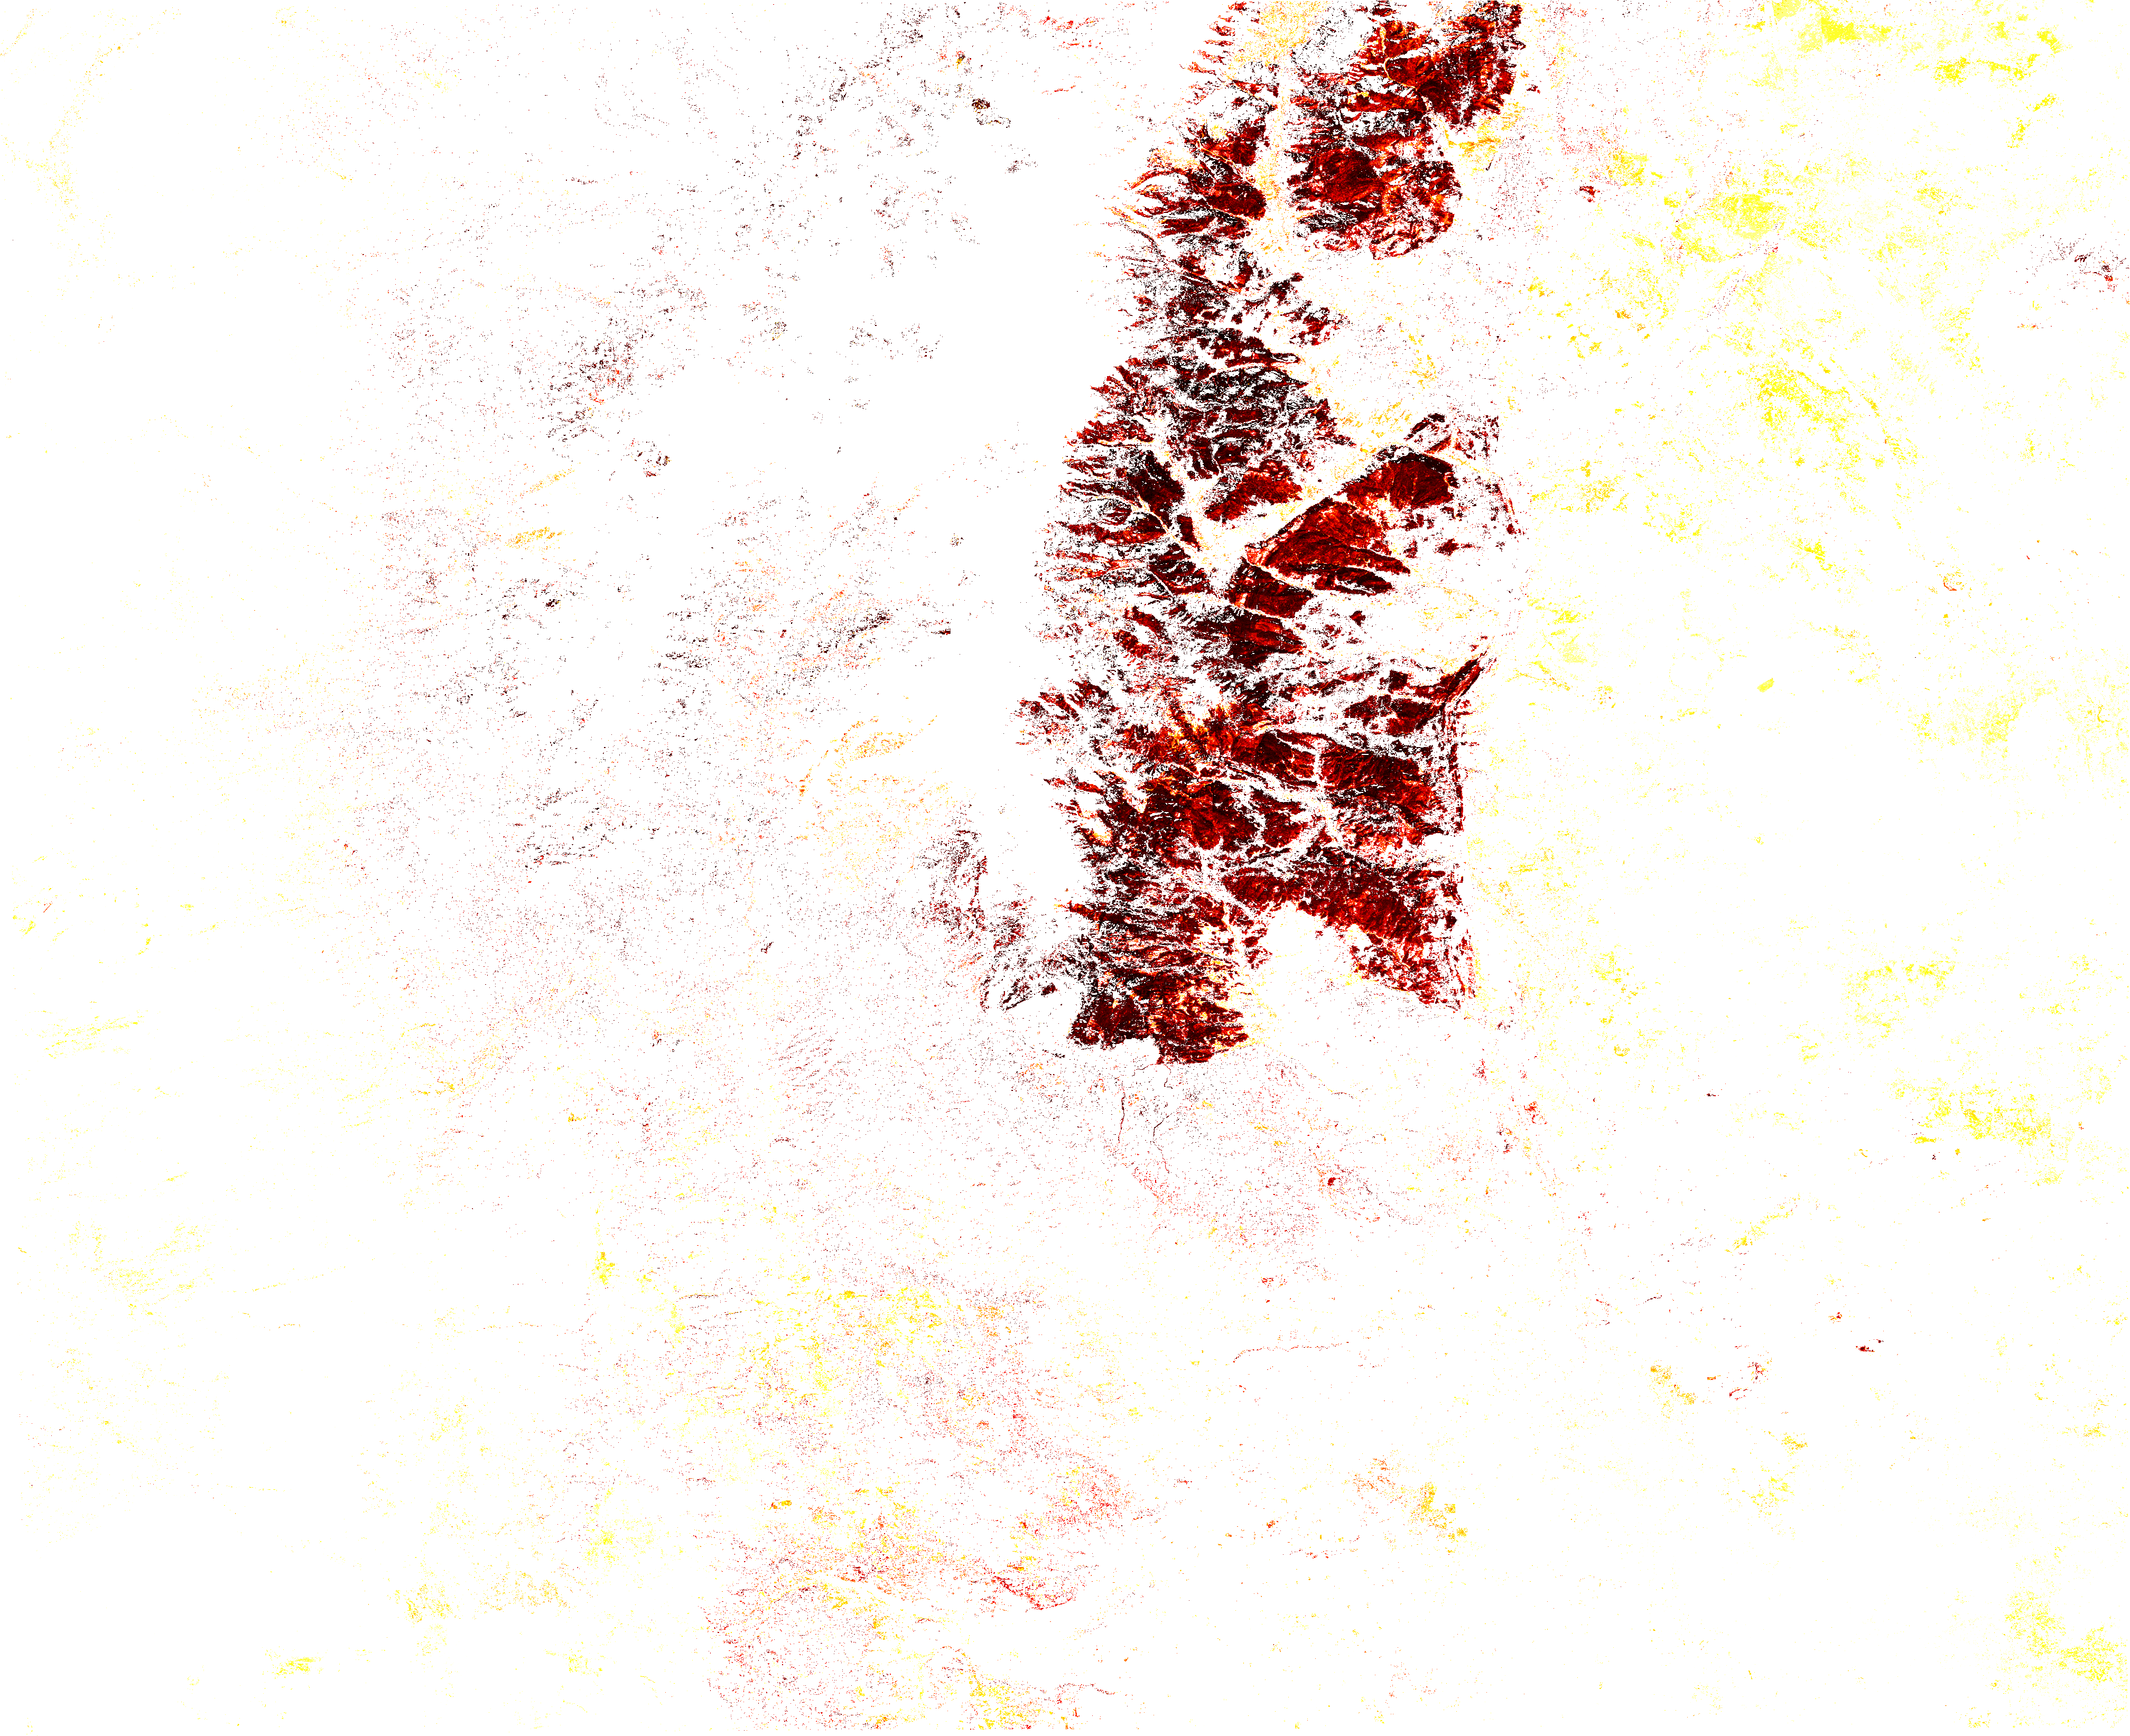
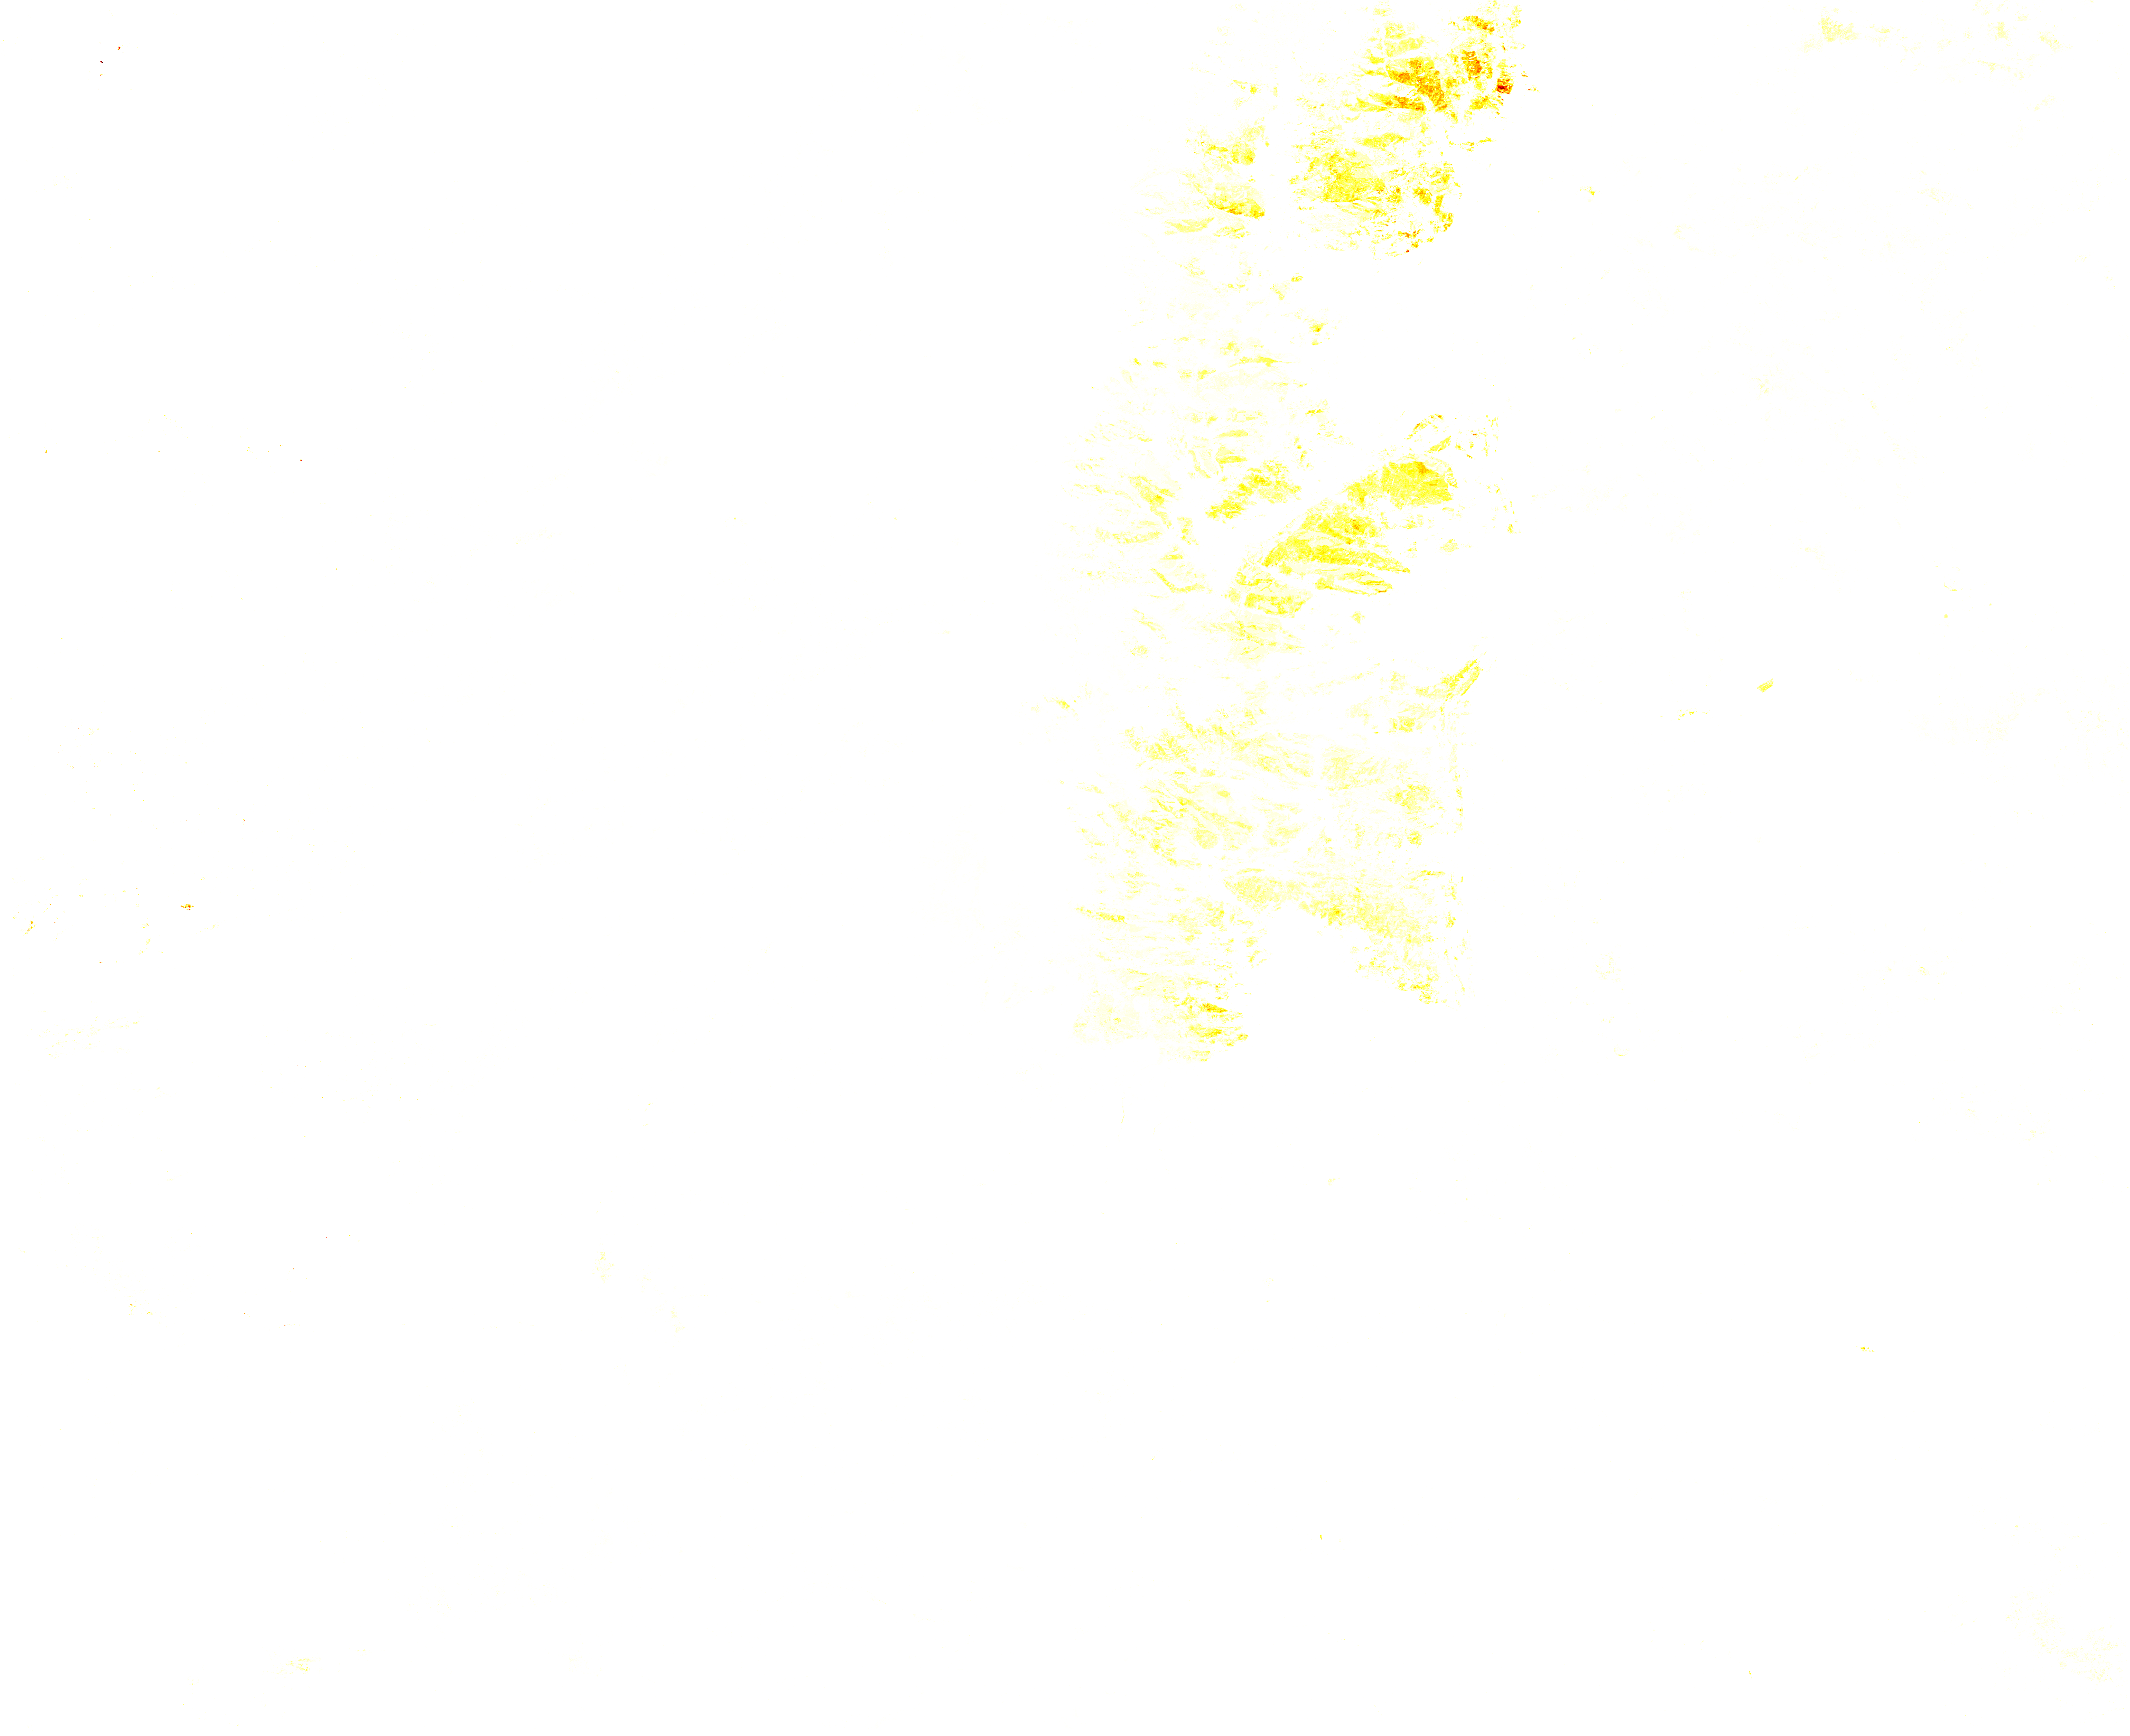
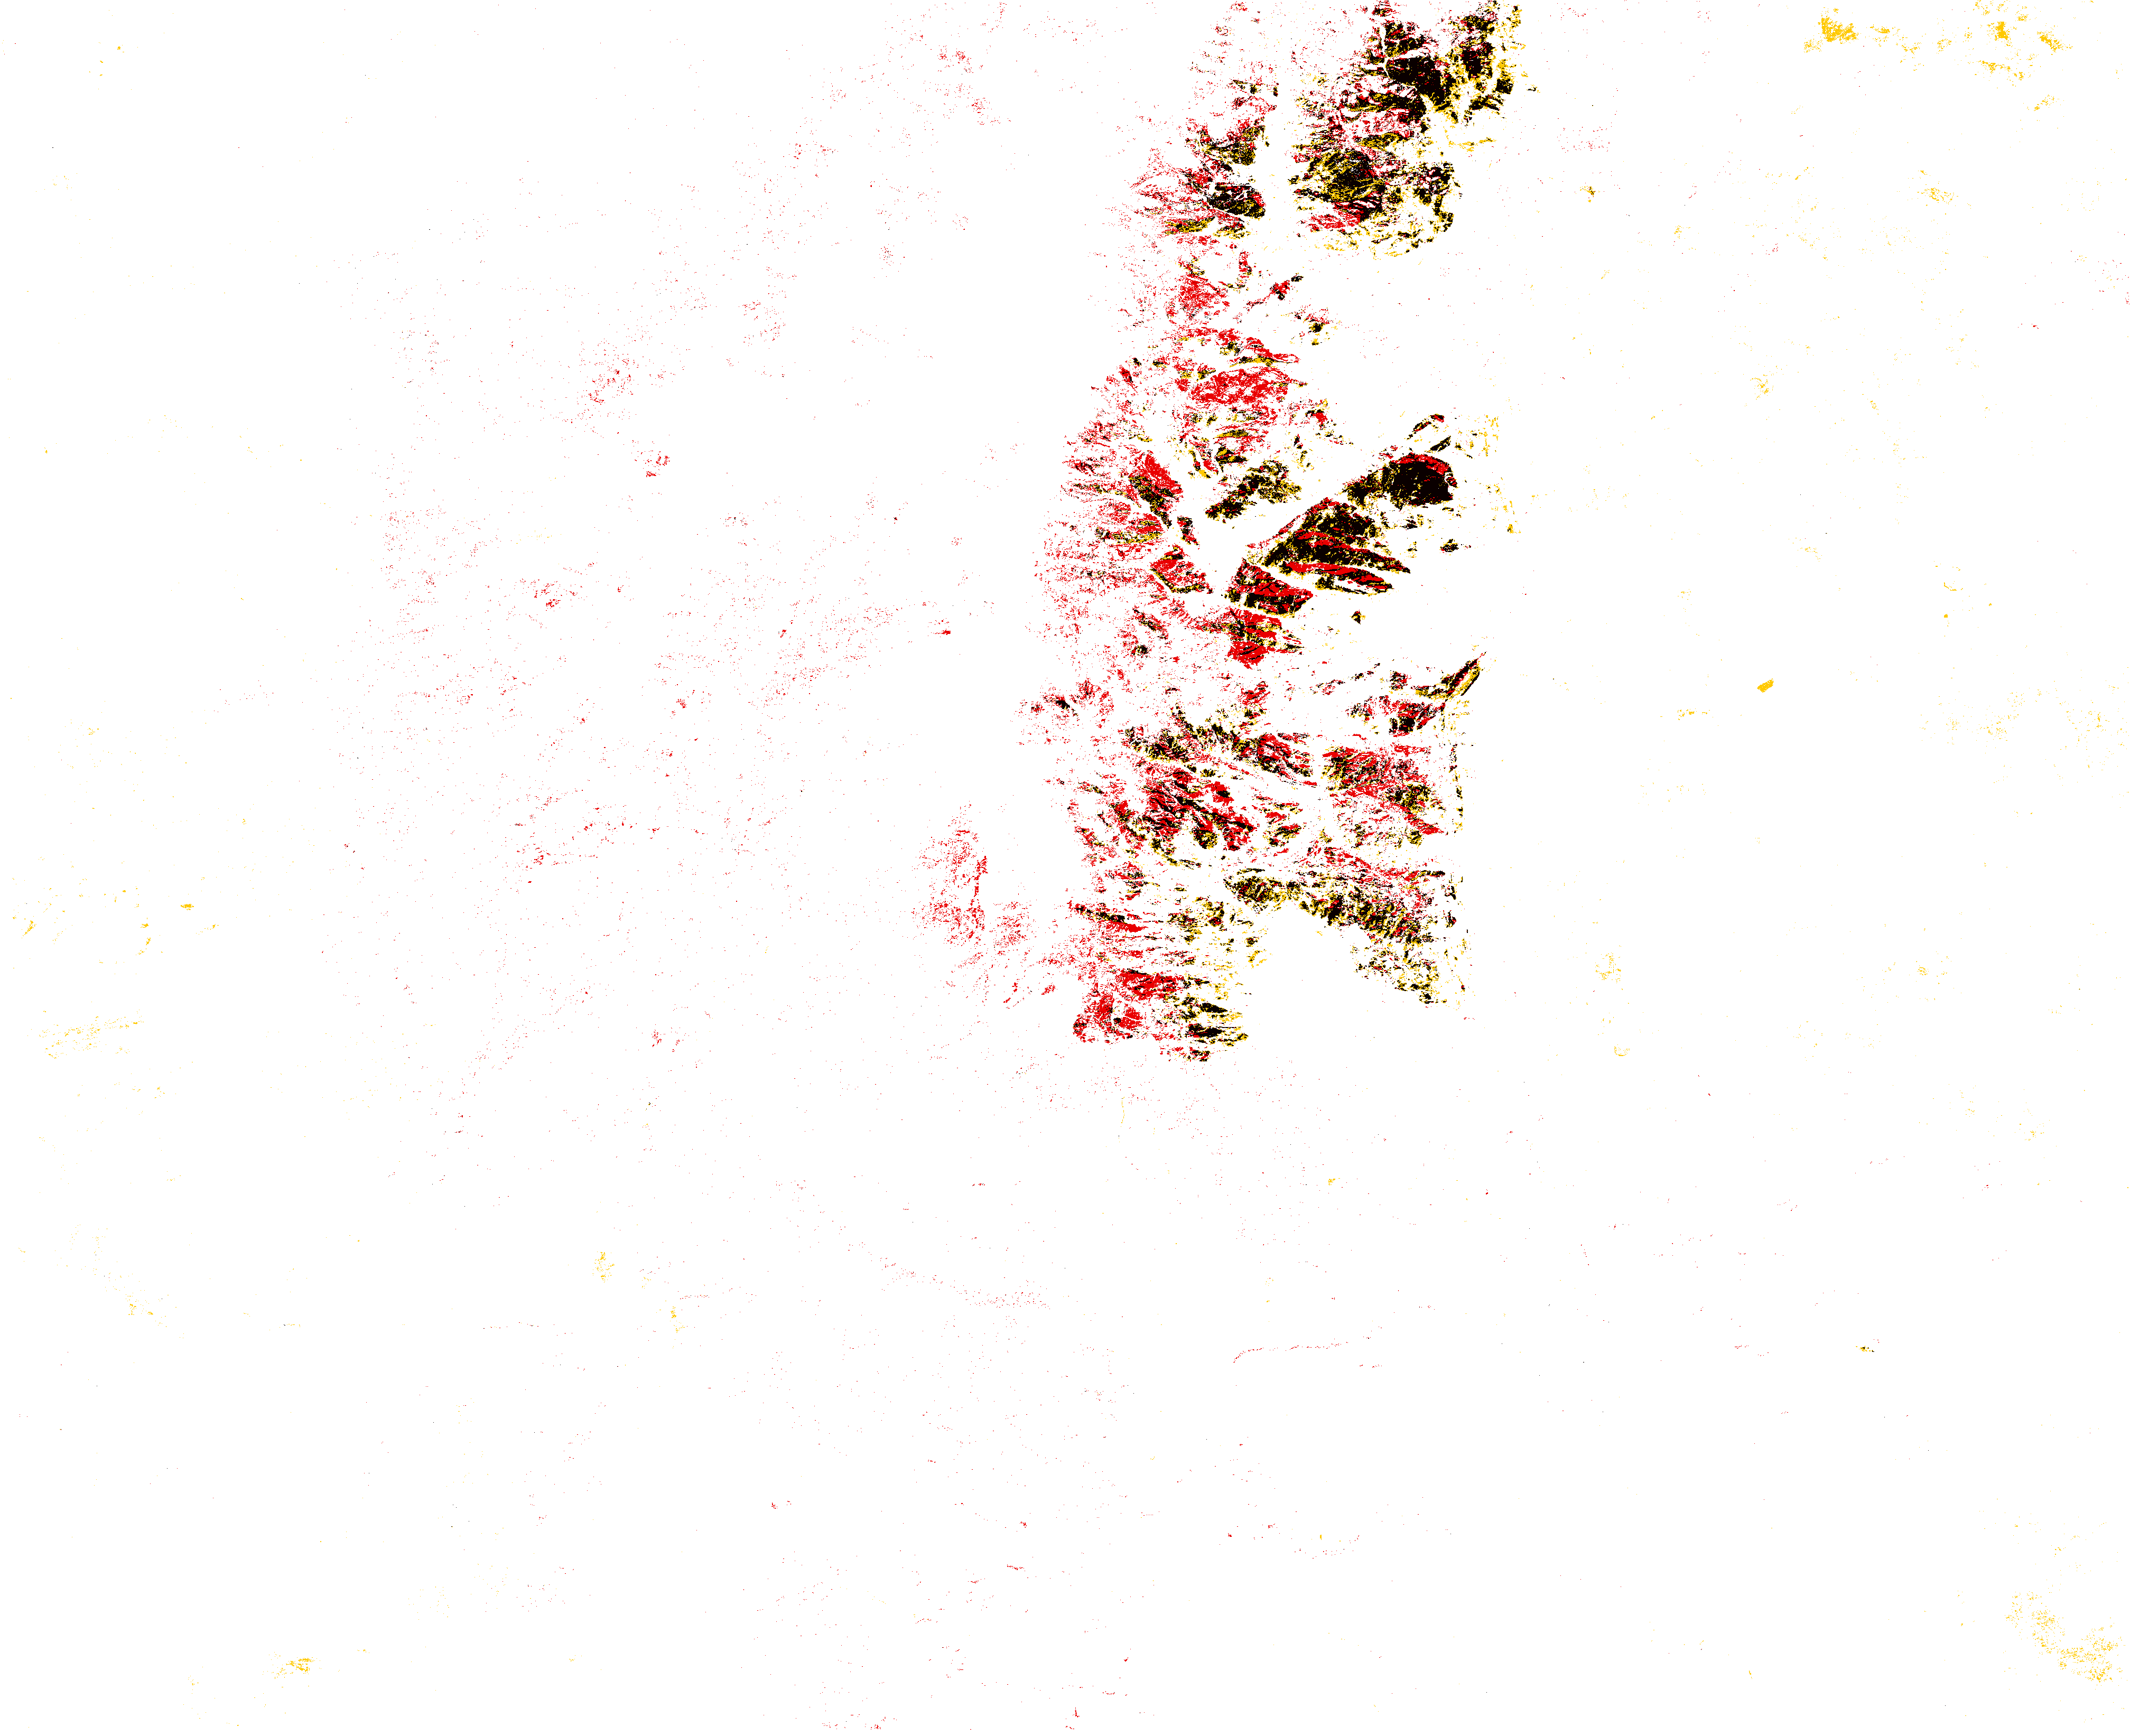

In [16]:
# Initialize Folium basemap
xmid =(merged_VEG_ANOM_MAX.x.values.min()+merged_VEG_ANOM_MAX.x.values.max())/2 ; ymid = (merged_VEG_ANOM_MAX.y.values.min()+merged_VEG_ANOM_MAX.y.values.max())/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='CartoDB positron', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_ANOM_MAX, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_ANOM_MAX.y.values.min(),merged_VEG_ANOM_MAX.x.values.min()],[merged_VEG_ANOM_MAX.y.values.max(),merged_VEG_ANOM_MAX.x.values.max()]],
                                        name='VEG_ANOM_MAX',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_DATE, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_DATE.y.values.min(),merged_VEG_DIST_DATE.x.values.min()],[merged_VEG_DIST_DATE.y.values.max(),merged_VEG_DIST_DATE.x.values.max()]],
                                        name='VEG_DIST_DATE',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_STATUS, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_STATUS.y.values.min(),merged_VEG_DIST_STATUS.x.values.min()],[merged_VEG_DIST_STATUS.y.values.max(),merged_VEG_DIST_STATUS.x.values.max()]],
                                        name='VEG_DIST_STATUS',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=200, height=200)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m